In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import shap

In [2]:
df=pd.read_csv(r"C:\Users\ankam\OneDrive\Desktop\Research\crop_yield_data.csv")
df.head()

,Soil Moisture,Temperature,Nitrogen,Rainfall,Soil,Crop Yield
0,45,22,120,200,6.5,1
1,50,25,100,180,6.8,0
2,30,30,80,150,6.0,0
3,60,20,150,220,6.7,1
4,55,23,110,210,7.0,1


In [3]:
df.isnull().sum()

Soil Moisture    0
Temperature      0
Nitrogen         0
Rainfall         0
Soil             0
Crop Yield       0
dtype: int64

In [4]:
x=df.drop(['Crop Yield'],axis=1)
y=df['Crop Yield']

In [9]:
from sklearn.model_selection import train_test_split
x_train,x_test,y_train,y_test=train_test_split(x,y,test_size=.30,random_state=0)


In [11]:
from sklearn.ensemble import RandomForestRegressor
model=RandomForestRegressor()
model.fit(x,y)

RandomForestRegressor()

In [13]:
y_pred= model.predict(x_test)

In [15]:
explainer=shap.TreeExplainer(model)
shap_values=explainer.shap_values(x)

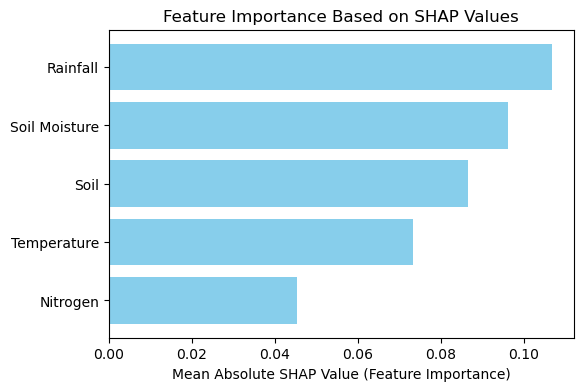

In [17]:
feature_importance = np.abs(shap_values).mean(axis=0)

# Create a DataFrame to hold feature names and importance values
feature_importance_df = pd.DataFrame({
    "Feature": x.columns,
    "Importance": feature_importance
})

# Sort by importance in descending order
feature_importance_df = feature_importance_df.sort_values(by="Importance", ascending=False)

# Plot the feature importance bar plot
plt.figure(figsize=(6, 4))
plt.barh(feature_importance_df["Feature"], feature_importance_df["Importance"], color="skyblue")
plt.xlabel("Mean Absolute SHAP Value (Feature Importance)")
plt.title("Feature Importance Based on SHAP Values")
plt.gca().invert_yaxis()  # Invert y-axis to have the most important feature at the top
plt.show()

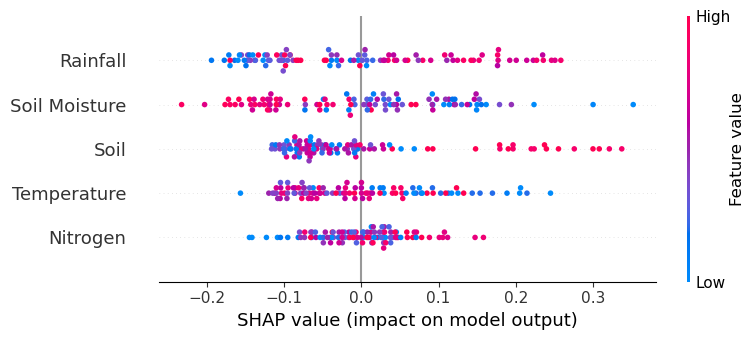

In [19]:
shap.summary_plot(shap_values, x)

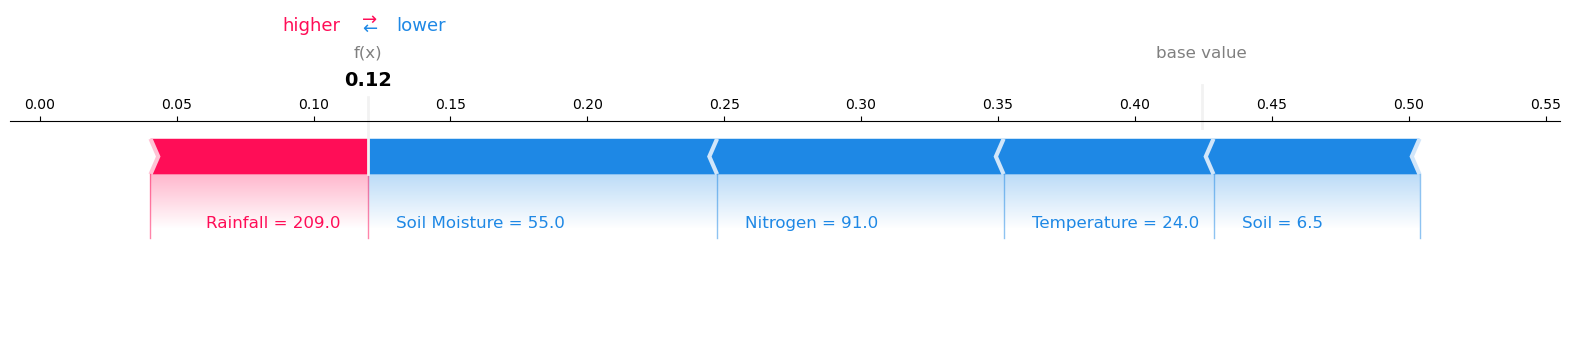

In [21]:
shap.force_plot(
        explainer.expected_value[0],  # Base value (expected value)
        shap_values[75],  # SHAP values for the selected instance
        x.iloc[75],  # Feature values for the selected instance
        matplotlib=True  # Use matplotlib for inline plots
    )
    # Display the plot
plt.show()

In [22]:
from sklearn.metrics import mean_squared_error,mean_absolute_error,r2_score
mae=mean_absolute_error(y_test,y_pred)
mse=mean_squared_error(y_test,y_pred)
r2=r2_score(y_test,y_pred)
print(f"Mean Absolute Error (MAE): {mae:.4f}")
print(f"Mean Squared Error (MSE): {mse:.4f}")
print(f"R² Score: {r2:.4f}")

Mean Absolute Error (MAE): 0.1763
Mean Squared Error (MSE): 0.0376
R² Score: 0.8432


In [25]:
import joblib
# Save the model
joblib.dump(model, "agriculture_rf_model.joblib")

['agriculture_rf_model.joblib']

In [27]:
streamlit_code="""
import streamlit as st
import shap
import numpy as np
import joblib
import streamlit.components.v1 as components
import matplotlib.pyplot as plt

# Function to render SHAP force plot properly
def st_shap(plot_html, height=300):
    components.html(plot_html, height=height)

# Load trained model
model = joblib.load("agriculture_rf_model.joblib")

# Streamlit UI Setup
st.set_page_config(page_title="🌾 Crop Yield Prediction", layout="wide")
st.title("🌾 Crop Yield Prediction & SHAP Analysis")

# Sidebar Inputs
st.sidebar.header("🔢 Enter Environmental Conditions")
soil_moisture = st.sidebar.number_input("Soil Moisture (%)", min_value=0.0, format="%.2f")
temperature = st.sidebar.number_input("Temperature (°C)", min_value=-10.0, max_value=50.0, format="%.2f")
nitrogen = st.sidebar.number_input("Nitrogen Content (mg/kg)", min_value=0.0, format="%.2f")
rainfall = st.sidebar.number_input("Rainfall (mm)", min_value=0.0, format="%.2f")
soil_ph = st.sidebar.number_input("Soil pH Level", min_value=4.0, max_value=9.0, format="%.2f")

st.markdown("---")

if st.sidebar.button("🚀 Predict Crop Yield"):
    # Convert input to NumPy array
    user_input = np.array([[soil_moisture, temperature, nitrogen, rainfall, soil_ph]])
    
    # Make Prediction
    yield_prediction = model.predict(user_input).item()
    st.success(f"### 🎯 Predicted Crop Yield: *{yield_prediction:.2f} kg/ha*")

    # SHAP Explanation
    explainer = shap.Explainer(model)
    shap_values = explainer(user_input)

    # ✅ Create SHAP force plot
    shap.initjs()
    force_plot = shap.plots.force(
        explainer.expected_value, 
        shap_values.values[0], 
        feature_names=["Soil Moisture", "Temperature", "Nitrogen", "Rainfall", "Soil pH"]
    )

    # ✅ Save SHAP plot as an HTML file
    shap_html_path = "shap_force_plot.html"
    shap.save_html(shap_html_path, force_plot)

    # ✅ Read the HTML file
    with open(shap_html_path, "r", encoding="utf-8") as f:
        force_plot_html = f.read()

    # ✅ Display SHAP Force Plot in Streamlit
    st_shap(force_plot_html, height=300)

    # ✅ Interpretation Message
    threshold = 0.5
    if yield_prediction >= threshold:
        st.success("✅ *High Crop Yield Expected!* Favorable conditions detected.")
    else:
        st.warning("⚠ *Low Crop Yield Detected!* Conditions may need improvement.")

st.sidebar.success("✅ Adjust values and click 'Predict' to analyze crop yield.")
"""
with open("crop_yield_app.py", "w", encoding="utf-8") as file:
    file.write(streamlit_code)

print(" Streamlit app saved as 'crop_yield_app.py'")

 Streamlit app saved as 'crop_yield_app.py'


In [ ]:
!streamlit run crop_yield_app.py